In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_arch_list())

print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
       
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Using device: cuda
['sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']
Is CUDA supported by this system?True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce MX230


In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import torch
torch.cuda.empty_cache()

In [1]:
import onnx
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from PIL import Image
from torch import optim
from tqdm import tqdm
import netron
import time
from IPython.display import IFrame


# # Define paths
train_dir = "datasets/rgb_data_old/train"
test_dir = "datasets/rgb_data_old/test"

# train_dir = "datasets/rgb_data_new/train"
# test_dir = "datasets/rgb_data_new/test"


# Define transforms
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# train_dir = "grayscale_data/train"
# test_dir = "grayscale_data/test"

# # Grayscale
# transform = transforms.Compose([
#     transforms.Resize((227, 227)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485], std=[0.229])
# ])


class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)

    def __len__(self):
        total_images = sum(len(files) for _, _, files in os.walk(self.data_dir))
        return total_images

    def __getitem__(self, idx):
        class_idx = idx // (len(os.listdir(os.path.join(self.data_dir, self.classes[0]))))
        class_dir = os.path.join(self.data_dir, self.classes[class_idx])
        files = os.listdir(class_dir)
        file_idx = idx % len(files)
        img_name = os.path.join(class_dir, files[file_idx])
        image = Image.open(img_name)
        label = class_idx
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets and dataloaders
train_dataset = CustomDataset(train_dir, transform=transform)
test_dataset = CustomDataset(test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def show_netron(model_path, port):
    time.sleep(3.)
    netron.start(model_path, address=("localhost", port), browse=False)
    return IFrame(src=f"http://localhost:{port}/", width="100%", height=400)


In [ ]:
import torch
import torch.nn as nn
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU, QuantIdentity
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat, Int8Bias
from brevitas.quant.scaled_int import Int8BiasPerTensorFloatInternalScaling  


class ECGNetOG(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        myWeight_bit_width = 4
        act_bit_width = 4

        self.features = nn.Sequential(
            QuantIdentity(act_quant = Int8ActPerTensorFloat,return_quant_tensor=True),

            QuantConv2d(3, 12, kernel_size=3, padding=1,input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,weight_quant=Int8WeightPerTensorFloat, 
                        bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width),

            QuantReLU(bit_width=act_bit_width, max_val=6, act_quant=Int8ActPerTensorFloat, 
                      input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True),

            QuantConv2d(12, 12, kernel_size=3, padding=1, input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,weight_quant=Int8WeightPerTensorFloat, 
                        bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width),

            QuantReLU(bit_width=act_bit_width, max_val=6, act_quant=Int8ActPerTensorFloat, 
                      input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True),

            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Dropout2d(0.5),

            QuantConv2d(12, 32, kernel_size=3, padding=1,input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,weight_quant=Int8WeightPerTensorFloat, 
                        bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width),

            QuantReLU(bit_width=act_bit_width, max_val=6, act_quant=Int8ActPerTensorFloat, 
                      input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True),

            QuantConv2d(32, 32, kernel_size=3, padding=1, input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,weight_quant=Int8WeightPerTensorFloat, 
                        bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width),

            QuantReLU(bit_width=act_bit_width, max_val=6, act_quant=Int8ActPerTensorFloat, 
                      input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True),

            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Dropout2d(0.5),
        )

        self.classifier = nn.Sequential(
            QuantLinear(32 * 25 * 25, 144, bias=True, weight_quant=Int8WeightPerTensorFloat, bias_quant=Int8BiasPerTensorFloatInternalScaling, 
                        input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True,weight_bit_width=myWeight_bit_width),
            QuantReLU(bit_width=act_bit_width, max_val=6, act_quant=Int8ActPerTensorFloat, 
                      input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True),
            QuantLinear(144, num_classes, bias=True, weight_quant=Int8WeightPerTensorFloat, bias_quant=Int8BiasPerTensorFloatInternalScaling, 
                        input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True,weight_bit_width=myWeight_bit_width)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 32 * 25 * 25)  # Flatten the output
        x = self.classifier(x)
        return x

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from brevitas.nn import QuantConv2d, QuantReLU, QuantLinear
from brevitas.quant.scaled_int import Int8ActPerTensorFloat
from brevitas.quant.scaled_int import Int8WeightPerTensorFloat
from brevitas.quant.scaled_int import Int8BiasPerTensorFloatInternalScaling


class QuantMobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        myWeight_bit_width = 4
        act_bit_width = 4

        self.inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        self.conv1 = QuantConv2d(3, 32, kernel_size=3, stride=2, padding=1,  bias=True, input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,
                        weight_quant=Int8WeightPerTensorFloat, bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width)
        self.relu = QuantReLU(bit_width=act_bit_width, max_val=6, act_quant=Int8ActPerTensorFloat, 
                      input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True)
        self.features = self._make_layers(in_channels=32)
        self.conv_last = QuantConv2d(320, 1280, kernel_size=1,  bias=True, input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,
                        weight_quant=Int8WeightPerTensorFloat, bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = QuantLinear(1280, 2,  bias=True, input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,
                        weight_quant=Int8WeightPerTensorFloat, bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width)

    def _make_layers(self, in_channels):
        layers = []
        for t, c, n, s in self.inverted_residual_setting:
            for i in range(n):
                if i == 0:
                    layers.append(QuantBottleneck(in_channels, c, s, t))
                else:
                    layers.append(QuantBottleneck(in_channels, c, 1, t))
                in_channels = c
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.features(x)
        x = self.conv_last(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class QuantBottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, stride, expansion):
        super(QuantBottleneck, self).__init__()
        
        myWeight_bit_width = 4
        act_bit_width = 4

        self.stride = stride
        planes = expansion * in_planes
        self.conv1 = QuantConv2d(in_planes, planes, kernel_size=1, bias=True, input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,
                        weight_quant=Int8WeightPerTensorFloat, bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = QuantReLU(bit_width=act_bit_width, max_val=6, act_quant=Int8ActPerTensorFloat, 
                      input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True)
        self.conv2 = QuantConv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=True,
                                  weight_quant=Int8WeightPerTensorFloat, 
                                  act_quant=Int8ActPerTensorFloat)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = QuantReLU(bit_width=act_bit_width, max_val=6, act_quant=Int8ActPerTensorFloat, 
                      input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,return_quant_tensor=True)
        self.conv3 = QuantConv2d(planes, out_planes, kernel_size=1, bias=True, input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,
                        weight_quant=Int8WeightPerTensorFloat, bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                QuantConv2d(in_planes, out_planes, kernel_size=1, stride=stride,  bias=True, input_quant=Int8ActPerTensorFloat,output_quant=Int8ActPerTensorFloat,
                        weight_quant=Int8WeightPerTensorFloat, bias_quant=Int8BiasPerTensorFloatInternalScaling, return_quant_tensor=True,weight_bit_width=myWeight_bit_width),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x) if self.stride == 1 else out
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
np.random.seed(0)

model = ECGNetOG()
model.to(device)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
np.random.seed(0)

model = QuantMobileNetV2()

model.to(device)


QuantMobileNetV2(
  (conv1): QuantConv2d(
    3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ParameterFromRuntimeStatsScaling(
            (stats_input_view_shape_impl): OverTensorView()
            (stats): _Stats(
              (stats_impl): AbsPercentile()
            )
            (restrict_scaling): _RestrictValue(
              (restrict_value_impl): FloatRestrictValue()
            )
            (clamp_scaling): _ClampValue(
              (clamp_min_ste): ScalarClampMinSte()
        

In [ ]:
num_epochs = 30

# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available is not None:
    criterion = criterion.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    correct_train = 0
    total_train = 0


    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training', leave=True)
    for images, labels in train_progress_bar:
        images, labels = images.to(device), labels.to(device)
        # forward pass
        optimizer.zero_grad()
        outputs = model(images)
        # backward pass + run optimizer to update weights
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # keep track of loss value
        train_running_loss += loss.item()

        pred = torch.argmax(outputs,dim=1)      #torch.max(outputs, 1)   
        total_train += labels.size(0)
        correct_train += (pred == labels).sum().item()

        train_progress_bar.set_postfix(loss=f'{train_running_loss/(len(train_progress_bar)):.4f}')

    train_loss_avg = train_running_loss / len(train_loader)
    train_losses.append(train_loss_avg)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss_avg:.4f}')

    # Testing phase
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0

    test_progress_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} Validation', leave=True)

    with torch.no_grad():
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            predicted = torch.argmax(outputs,dim=1)

            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            test_progress_bar.set_postfix(val_loss=f'{test_running_loss/(len(test_progress_bar)):.4f}')
    test_loss_avg = test_running_loss / len(test_loader)
    test_losses.append(test_loss_avg)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    lr_scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {test_loss_avg:.4f},Validation Accuracy: {test_accuracy:.4f}')

print("Training Finished!")


In [ ]:
import matplotlib.pyplot as plt

# Plotting training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
model_path = "trained_models/mobilenetv2_w4a4_model.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)

QuantMobileNetV2(
  (conv1): QuantConv2d(
    3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ParameterFromRuntimeStatsScaling(
            (stats_input_view_shape_impl): OverTensorView()
            (stats): _Stats(
              (stats_impl): AbsPercentile()
            )
            (restrict_scaling): _RestrictValue(
              (restrict_value_impl): FloatRestrictValue()
            )
            (clamp_scaling): _ClampValue(
              (clamp_min_ste): ScalarClampMinSte()
        

C:\Users\asrin\AppData\Local\Temp\ipykernel_6312\1273567258.py:17: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:298.)
  _, predicted = torch.max(outputs, 1)


Validation Accuracy Score: 0.9439024390243902
F1 Score: 0.943781708487591


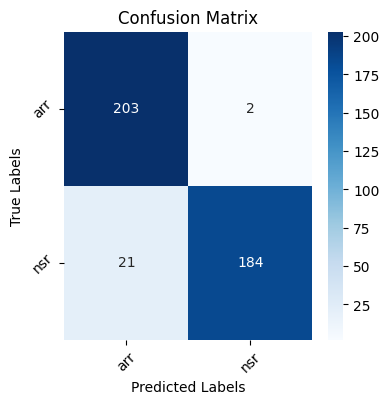

In [7]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets

# Define a function for validation
def validate(model, validation_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred



validation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# # Grayscale
# validation_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485], std=[0.229])
# ])

validation_dir = "datasets/rgb_data_old_validation"
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=validation_transform)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
  


# Perform validation
y_true, y_pred = validate(model, validation_dataloader)

# Calculate accuracy score and f1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

# Print accuracy score and f1 score
print(f'Validation Accuracy Score: {accuracy}')
print(f'F1 Score: {f1}')


class_names = validation_dataset.classes


# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names, rotation=45)
ax.yaxis.set_ticklabels(class_names, rotation=45)
plt.show()


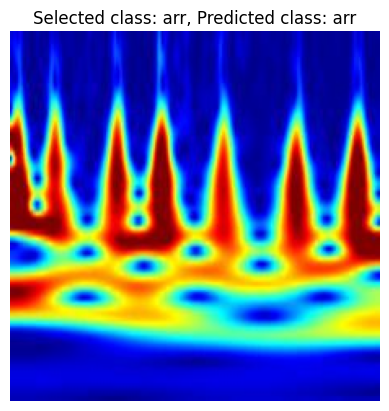

In [8]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os 
import random
import matplotlib.pyplot as plt

model_path = "trained_models/mobilenetv2_w4a4_model.pth"

# Load the model
model.load_state_dict(torch.load(model_path))
model.to("cpu") #Run on cpu only

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),                          
    transforms.ToTensor(),                                
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

classes = ["arr", "nsr"]

random_image_path = "datasets/rgb_data_old_validation/"  
random_image_class = random.choice(classes)  
random_image_filename = random.choice(os.listdir(os.path.join(random_image_path, random_image_class)))
random_image = Image.open(os.path.join(random_image_path, random_image_class, random_image_filename))


input_image = transform(random_image)
input_image = input_image.unsqueeze(0)
input_image.to(device)               


with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    output = model(input_image)


_, predicted_class_index = output.tensor.max(1)
predicted_class = classes[predicted_class_index.item()]

plt.imshow(random_image)
plt.title("Selected class: " + random_image_class + ", Predicted class: " + predicted_class)
plt.axis('off')
plt.show()